In [19]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import snowflake.connector

In [20]:
# Set the theme for all plots
sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = (12, 6) # Standardize size

In [21]:
# Gets the version
ctx = snowflake.connector.connect(
    user='juno',
    password=os.getenv("SNOWFLAKE_PW"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse="compute_wh",
    database="walmart_db",
    schema="gold"
    )
# Create a cursor object.
cur = ctx.cursor()

def query(sql):
    cur.execute(sql)  # Execute a statement that will generate a result set
    df = cur.fetch_pandas_all()  # Fetch the result set from the cursor and deliver it as the pandas DataFrame
    return df

In [22]:
%%markdown
# Data prep

# Data prep


In [23]:
df = query("select * from weekly_sales")
df.columns = df.columns.str.lower()
df["store_date"] = pd.to_datetime(df["store_date"])
df["year"] = df["store_date"].dt.year
df["day"] = df["store_date"].dt.day
df["month"] = df["store_date"].dt.month_name()
df["month_num"] = df["store_date"].dt.month
# df.to_csv("weekly_sales.csv", index=False)

y10 = df[df['year'] == 2010]
y11 = df[df['year'] == 2011]
y12 = df[df['year'] == 2012]

# df.info()
# df.columns # ['store_id', 'store_date', 'isholiday', 'dept_id', 'store_type','store_size', 'store_weekly_sales', 'fuel_price', 'store_temperature','unemployment', 'cpi', 'markdown1', 'markdown2', 'markdown3','markdown4', 'markdown5', 'year', 'month']

In [24]:
%%markdown
# Plot functions

# Plot functions


In [25]:
def thousands(x, pos):
    return f"{x/1e3:.0f}K"
    
def millions(x, pos):
    return f"{x/1e6:.0f}M"

def billions(x, pos):
    return f"{x/1e9:.0f}B"

def plot(title, xlabel, ylabel, legend=None):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend: plt.legend(title=legend)
    plt.tight_layout()
    plt.show()


In [26]:
%%markdown
# Sales By Function

# Sales By Function


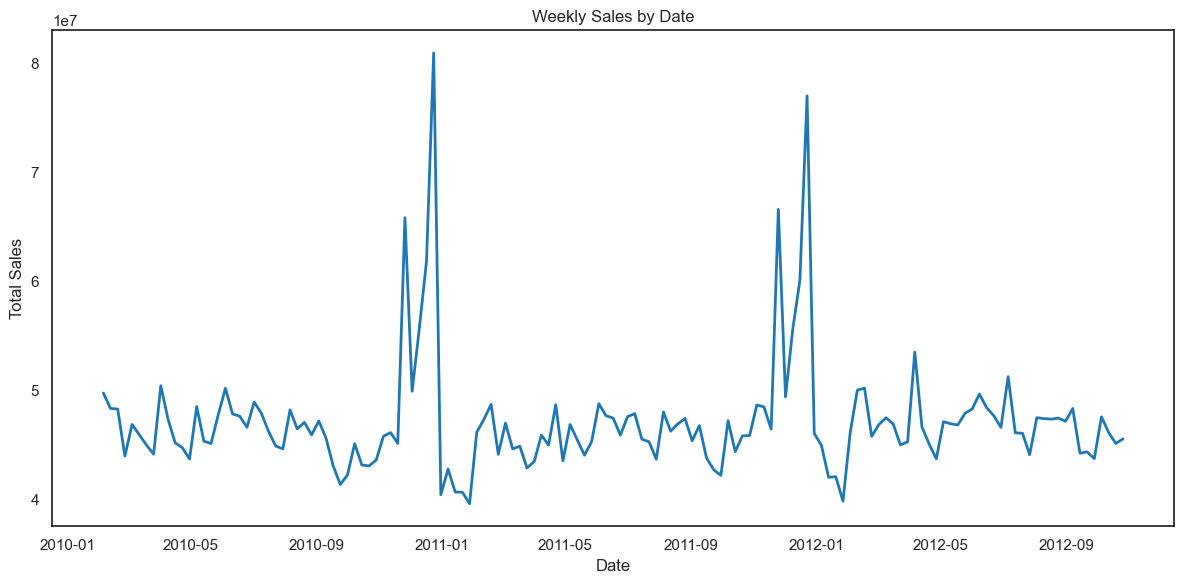

In [27]:
def sales_by(category, data=None):  # category can be str or list
    if data is None:
        data = df
    return (
        data.groupby(category, as_index=False)["store_weekly_sales"]
          .sum()
          .sort_values(category)
        )

def line_plot(df, title, xlabel=None, ylabel=None, x=None, y=None, legend=False):
    if x is None: x = df.columns[0]
    if y is None: y = df.columns[1]
    
    sns.lineplot(data=df, x=x, y=y, linewidth=2, color='tab:blue')
    plot(title, xlabel, ylabel, legend)    

line_plot(sales_by('store_date'), 'Weekly Sales by Date', 'Date', 'Total Sales')

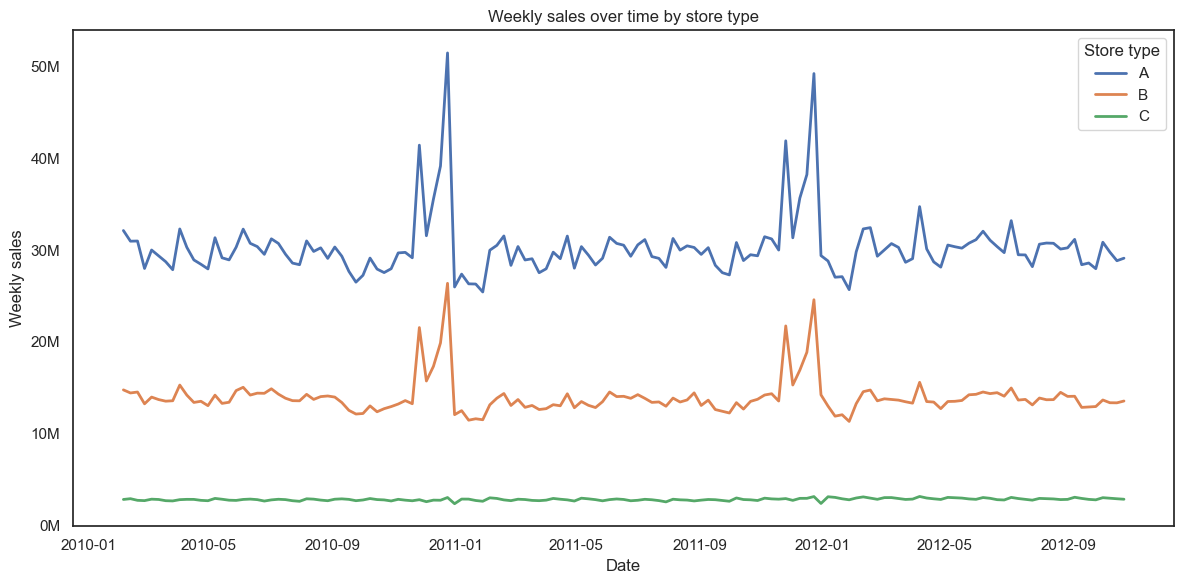

In [28]:
# sales over time by store type
sales_by_date_type = (
    df.groupby(["store_date", "store_type"], as_index=False)["store_weekly_sales"]
      .sum()
      .sort_values("store_date")
)

fig, ax = plt.subplots()

sns.lineplot(data=sales_by_date_type,
    x="store_date",y="store_weekly_sales",
    hue="store_type",
    linewidth=2,
    ax=ax
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

plot("Weekly sales over time by store type", "Date", "Weekly sales", legend="Store type")

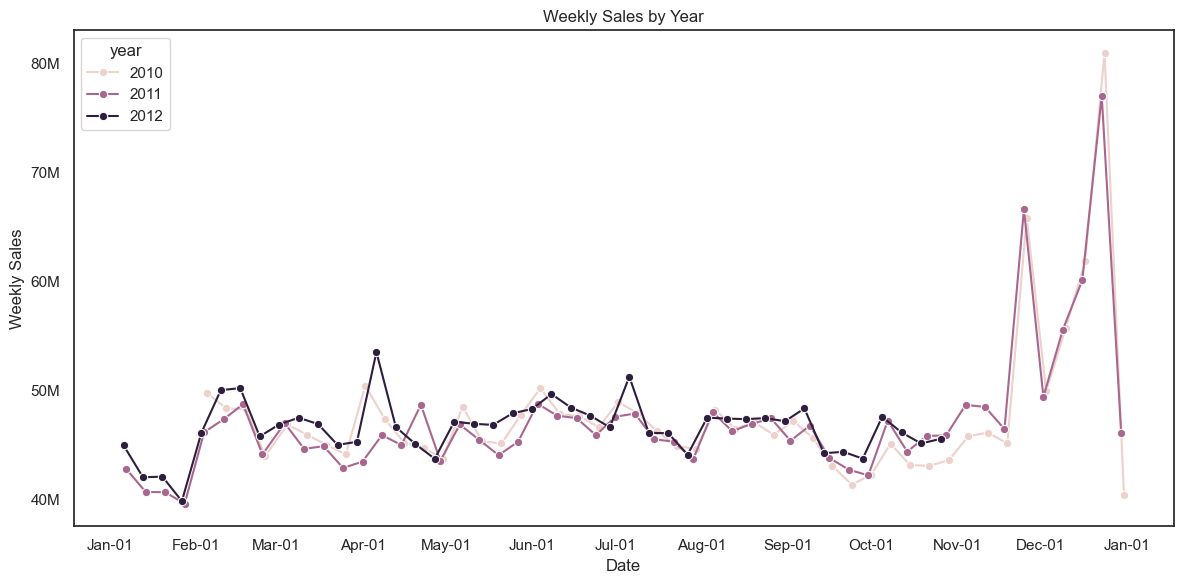

In [29]:
# align month-day across years with date using dummy year (2000)
df["md_date"] = pd.to_datetime( dict(year=2000, month=df["month_num"], day=df["day"]))

weekly = (
    df.groupby(["md_date", "year"], as_index=False)["store_weekly_sales"]
      .sum()
      .sort_values(["md_date", "year"])
)

fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    data=weekly,
    x="md_date",
    y="store_weekly_sales",
    hue="year",
    marker="o",
    ax=ax
)

# Show month-day on the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

plot("Weekly Sales by Year", "Date", "Weekly Sales")

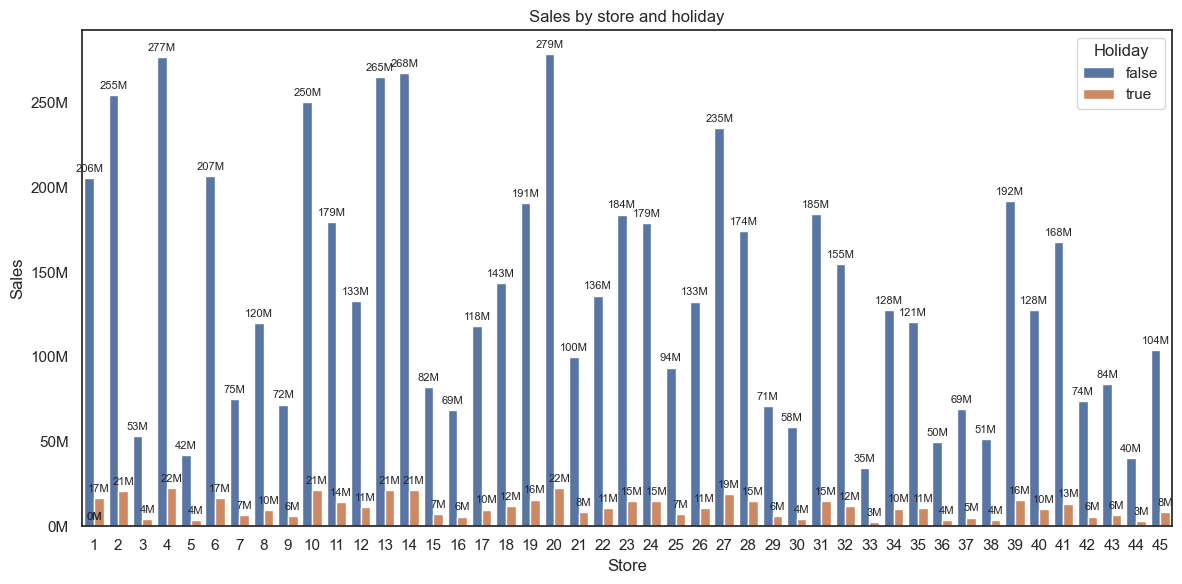

In [30]:
store_holiday = (
    df.groupby(["store_id", "isholiday"], as_index=False)["store_weekly_sales"]
      .sum()
      .sort_values(["store_id", "isholiday"])
)

fig, ax = plt.subplots()

sns.barplot(
    data=store_holiday,
    x="store_id",
    y="store_weekly_sales",
    hue="isholiday",
    ax=ax
)


ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# Add labels on each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        millions(height, None),
        (p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8
    )


plot("Sales by store and holiday", "Store", "Sales", legend="Holiday")

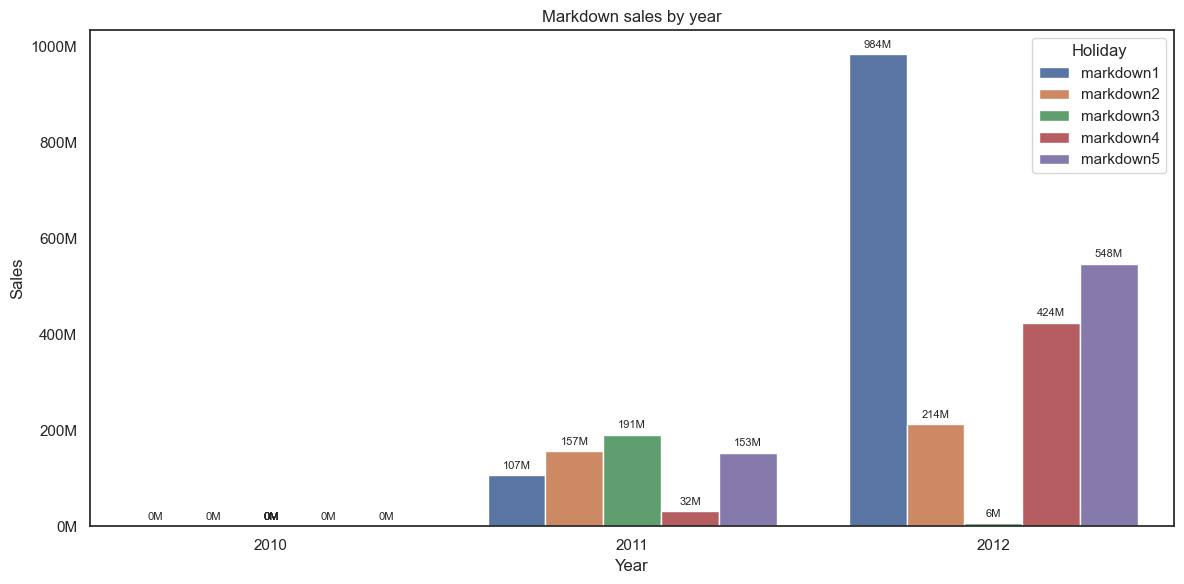

In [31]:
markdown_sales = (
    df.groupby(["year"], as_index=False)[["markdown1", "markdown2", "markdown3", "markdown4", "markdown5"]]
      .sum()
      .sort_values(["year"])
)

# reshape to long for seaborn
markdown_long = markdown_sales.melt(
    id_vars="year",
    value_vars=["markdown1", "markdown2", "markdown3", "markdown4", "markdown5"],
    var_name="markdown_type",
    value_name="sales"
)
markdown_long

fig, ax = plt.subplots()

sns.barplot(
    data=markdown_long,
    x="year",
    y="sales",
    hue="markdown_type",
    ax=ax
)


ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# Add labels on each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        millions(height, None),
        (p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8
    )


plot("Markdown sales by year", "Year", "Sales", legend="Holiday")


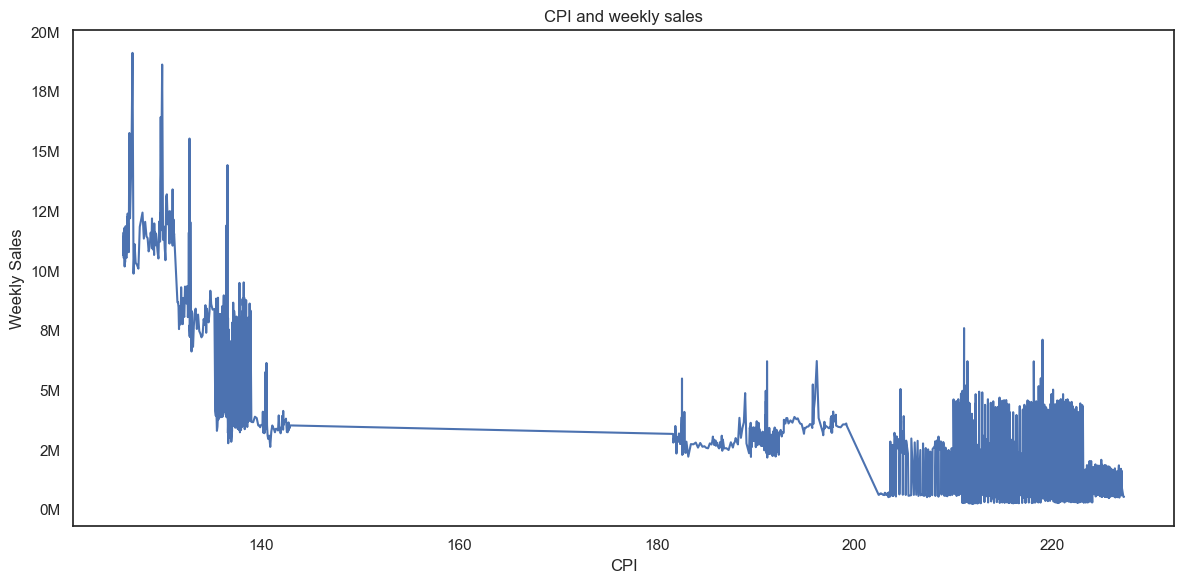

In [32]:
cpi_weekly_sales = (
    df.groupby('cpi', as_index=False)[["store_weekly_sales"]]
        .sum()
)

fig, ax = plt.subplots()

sns.lineplot(
    data=cpi_weekly_sales,
    x="cpi",
    y="store_weekly_sales",
    ax=ax
)


ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))


plot("CPI and weekly sales", "CPI", "Weekly Sales")


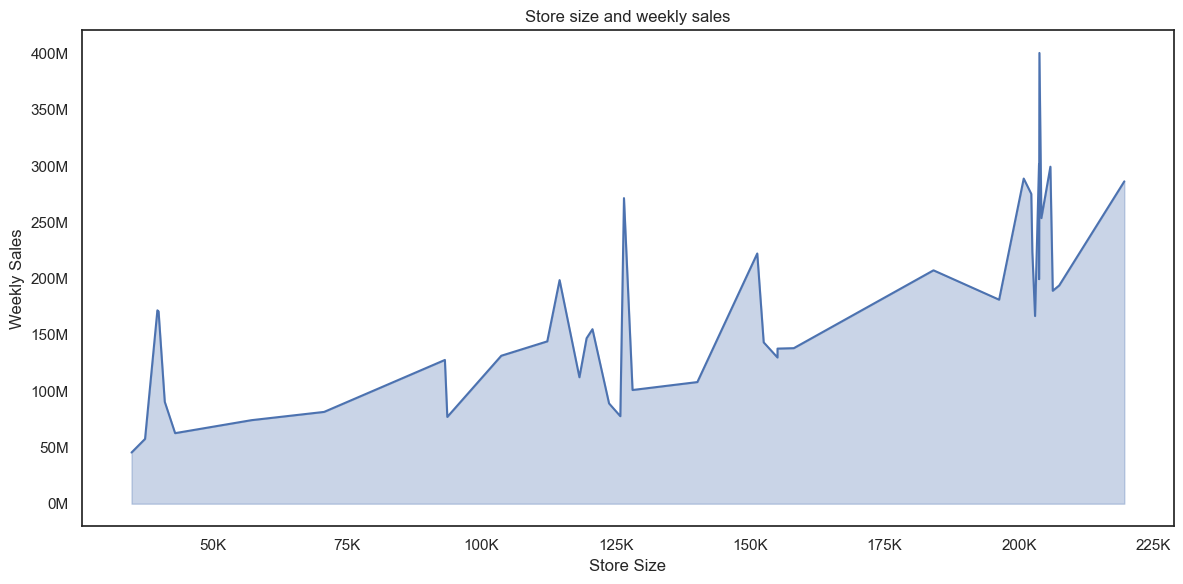

In [33]:
cpi_weekly_sales = (
    df.groupby('store_size', as_index=False)[["store_weekly_sales"]]
        .sum()
)

fig, ax = plt.subplots()

sns.lineplot(
    data=cpi_weekly_sales,
    x="store_size",
    y="store_weekly_sales",
    ax=ax
)

# Shade under the line
ax.fill_between(
    cpi_weekly_sales["store_size"],
    cpi_weekly_sales["store_weekly_sales"],
    0,  # fill down to y=0
    alpha=0.3,
    color=ax.lines[0].get_color(),
)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))


plot("Store size and weekly sales", "Store Size", "Weekly Sales")


In [34]:
cur.close()
ctx.close()